# Importing Libraries

In [78]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,roc_curve,roc_auc_score,plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

from pandas_profiling import ProfileReport

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas

ModuleNotFoundError: No module named 'geopandas'

# Importing datasets

In [79]:
train=pd.read_csv("training_set_features.csv",index_col="id")
train_labels=pd.read_csv("training_set_labels.csv",index_col="id")
test=pd.read_csv("test_set_features.csv",index_col="id")

# Exploring Data and Selecting Features

In [80]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [81]:
train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [82]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15

Find Target classes details

status_group           
functional                 32259
non functional             22824
functional needs repair     4317
dtype: int64


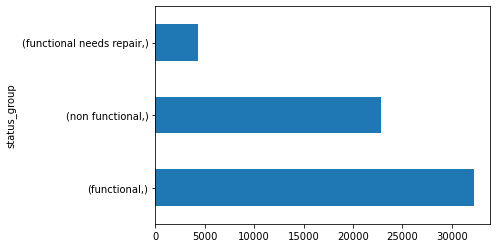

In [83]:
train_labels.value_counts().plot(kind = 'barh')
print(train_labels.value_counts())

In [84]:
# profile = ProfileReport(train, title="Pandas Profiling Report", explorative=True)
# profile.to_notebook_iframe()

In [85]:
train.shape

(59400, 39)

In [86]:
data = train.join(train_labels) #join with target classes

After some research about the datset and the data it was found that some columns are similar with respect to the water pump functionality. So, those identified columns are dropped to reduce the dimensions of the the dataset.<br> 
&emsp;management, management_group, scheme_management <br>
&emsp;quantity, quantity_group <br>
&emsp;water_quality, quality_group<br>
&emsp;source, source_type, source_class<br>
&emsp;extraction_type, Extraction_type_group, extraction_type_class <br>
&emsp;payment, payment_type <br>
&emsp;waterpoint_type, waterpoint_type_group <br>
&emsp;region, region_code, subvillage <br>

In [87]:
data['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [88]:
data['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [89]:
data['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [90]:
data.groupby(['management_group','management']).count() 

amount_tsh  date_recorded  funder  \
management_group management                                            
commercial       company                  685            685     663   
                 private operator        1971           1971    1957   
                 trust                     78             78      78   
                 water authority          904            904     836   
other            other                    844            844     837   
                 other - school            99             99      99   
parastatal       parastatal              1768           1768    1624   
unknown          unknown                  561            561     533   
user-group       vwc                    40507          40507   37632   
                 water board             2933           2933    2715   
                 wua                     2535           2535    2308   
                 wug                     6515           6515    6483   

                                   gps_height  installer  longitude  latitude  \
management_group management                                                     
commercial       company                  685        663        685       685   
                 private operator        1971       1959       1971      1971   
                 trust                     78         78         78        78   
                 water authority          904        836        904       904   
other            other                    844        831        844       844   
                 other - school            99         99         99        99   
parastatal       parastatal              1768       1626       1768      1768   
unknown          unknown                  561        527        561       561   
user-group       vwc                    40507      37630      40507     40507   
                 water board             2933       2714       2933      2933   
                 wua                     2535       2309       2535      2535   
                 wug                     6515       6473       6515      6515   

                                   wpt_name  num_private  basin  ...  \
management_group management                                      ...   
commercial       company                685          685    685  ...   
                 private operator      1971         1971   1971  ...   
                 trust                   78           78     78  ...   
                 water authority        904          904    904  ...   
other            other                  844          844    844  ...   
                 other - school          99           99     99  ...   
parastatal       parastatal            1768         1768   1768  ...   
unknown          unknown                561          561    561  ...   
user-group       vwc                  40507        40507  40507  ...   
                 water board           2933         2933   2933  ...   
                 wua                   2535         2535   2535  ...   
                 wug                   6515         6515   6515  ...   

                                   water_quality  quality_group  quantity  \
management_group management                                                 
commercial       company                     685            685       685   
                 private operator           1971           1971      1971   
                 trust                        78             78        78   
                 water authority             904            904       904   
other            other                       844            844       844   
                 other - school               99             99        99   
parastatal       parastatal                 1768           1768      1768   
unknown          unknown                     561            561       561   
user-group       vwc                       40507          40507     40507   
                 water board       

management_group is the grouped version of management column. So considering the cardinality management_group is dropped.

In [91]:
data['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [92]:
data['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [93]:
data['source'].value_counts() #low cardinality

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [94]:
data['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [95]:
data['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [96]:
data.groupby(['source_class','source']).count()

amount_tsh  date_recorded  funder  \
source_class source                                                    
groundwater  hand dtw                     874            874     868   
             machine dbh                11075          11075   10252   
             shallow well               16824          16824   16302   
             spring                     17021          17021   15870   
surface      dam                          656            656     647   
             lake                         765            765     763   
             rainwater harvesting        2295           2295    2099   
             river                       9612           9612    8715   
unknown      other                        212            212     204   
             unknown                       66             66      45   

                                   gps_height  installer  longitude  latitude  \
source_class source                                                             
groundwater  hand dtw                     874        868        874       874   
             machine dbh                11075      10246      11075     11075   
             shallow well               16824      16286      16824     16824   
             spring                     17021      15870      17021     17021   
surface      dam                          656        646        656       656   
             lake                         765        762        765       765   
             rainwater harvesting        2295       2096       2295      2295   
             river                       9612       8721       9612      9612   
unknown      other                        212        204        212       212   
             unknown                       66         46         66        66   

                                   wpt_name  num_private  basin  ...  payment  \
source_class source                                              ...            
groundwater  hand dtw                   874          874    874  ...      874   
             machine dbh              11075        11075  11075  ...    11075   
             shallow well             16824        16824  16824  ...    16824   
             spring                   17021        17021  17021  ...    17021   
surface      dam                        656          656    656  ...      656   
             lake                       765          765    765  ...      765   
             rainwater harvesting      2295         2295   2295  ...     2295   
             river                     9612         9612   9612  ...     9612   
unknown      other                      212          212    212  ...      212   
             unknown                     66           66     66  ...       66   

                                   payment_type  water_quality  quality_group  \
source_class source                                                             
groundwater  hand dtw                       874            874            874   
             machine dbh                  11075          11075          11075   
             shallow well                 16824          16824          16824   
             spring                       17021          17021          17021   
surface      dam                            656            656            656   
             lake                           765            765            765   
             rainwater harvesting          2295           2295           2295   
             river                         9612           9612           9612   
unknown      other                          212            212            212   
             unknown                         66             66             66   

                                   quantity  quantity_group  source_type  \
source_class source                                                        
groundwater  hand dtw                   874             874          874   
             machine db

In [97]:
data['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [98]:
data['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

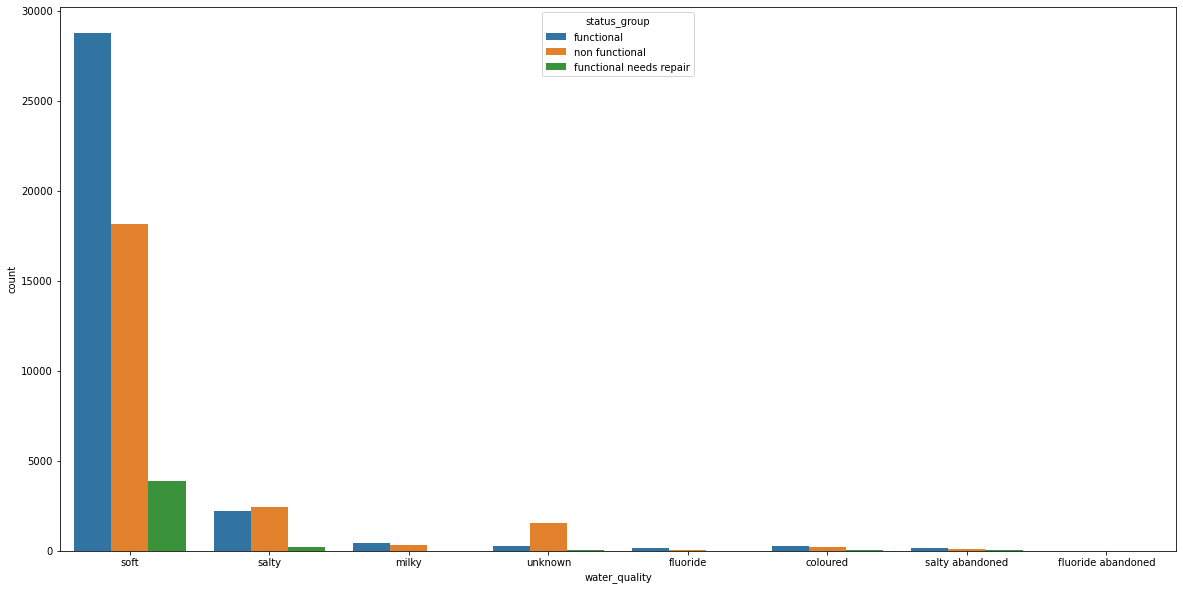

In [99]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='water_quality', hue="status_group", data=data) #more unique values, more information

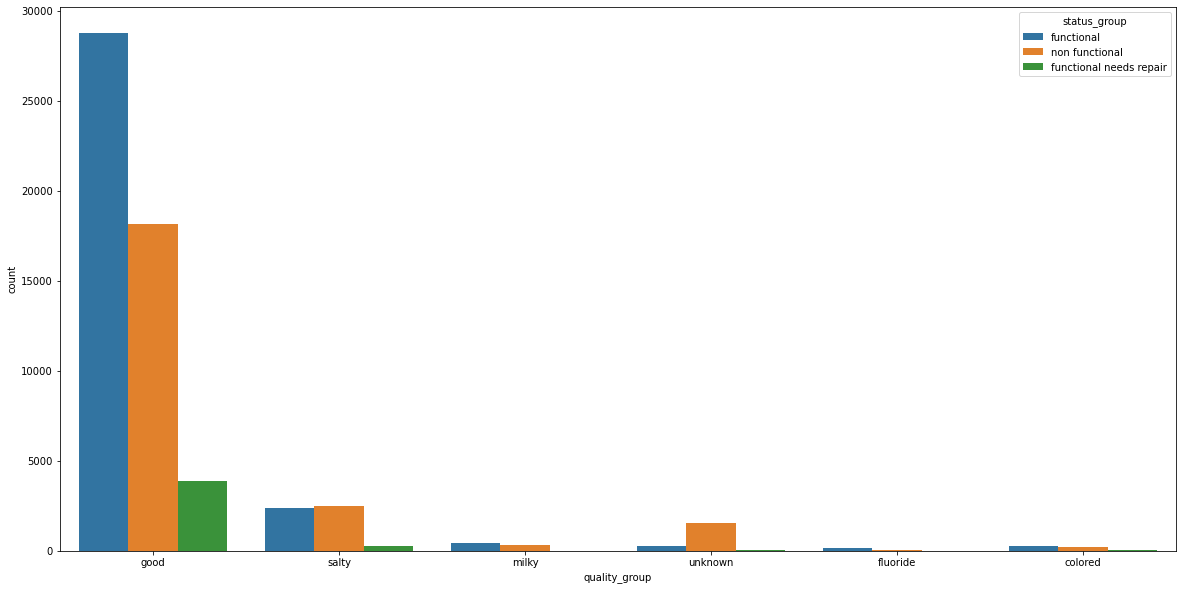

In [100]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='quality_group', hue="status_group", data=data)

In [101]:
data['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [102]:
data['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [103]:
data['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [104]:
data['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [105]:
data['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [106]:
data.groupby(['extraction_type_class','extraction_type_group']).count()

amount_tsh  date_recorded  \
extraction_type_class extraction_type_group                              
gravity               gravity                     26780          26780   
handpump              afridev                      1770           1770   
                      india mark ii                2400           2400   
                      india mark iii                 98             98   
                      nira/tanira                  8154           8154   
                      other handpump                364            364   
                      swn 80                       3670           3670   
motorpump             mono                         2865           2865   
                      other motorpump               122            122   
other                 other                        6430           6430   
rope pump             rope pump                     451            451   
submersible           submersible                  6179           6179   
wind-powered          wind-powered                  117            117   

                                             funder  gps_height  installer  \
extraction_type_class extraction_type_group                                  
gravity               gravity                 24704       26780      24714   
handpump              afridev                  1668        1770       1665   
                      india mark ii            2358        2400       2358   
                      india mark iii             98          98         98   
                      nira/tanira              7899        8154       7885   
                      other handpump            353         364        354   
                      swn 80                   3596        3670       3593   
motorpump             mono                     2577        2865       2578   
                      other motorpump           122         122        122   
other                 other                    6010        6430       6002   
rope pump             rope pump                 448         451        448   
submersible           submersible              5820        6179       5816   
wind-powered          wind-powered              112         117        112   

                                             longitude  latitude  wpt_name  \
extraction_type_class extraction_type_group                                  
gravity               gravity                    26780     26780     26780   
handpump              afridev                     1770      1770      1770   
                      india mark ii               2400      2400      2400   
                      india mark iii                98        98        98   
                      nira/tanira                 8154      8154      8154   
                      other handpump               364       364       364   
                      swn 80                      3670      3670      3670   
motorpump             mono                        2865      2865      2865   
                      other motorpump              122       122       122   
other                 other                       6430      6430      6430   
rope pump             rope pump                    451       451       451   
submersible           submersible                 6179      6179      6179   
wind-powered          wind-powered                 117       117       117   

                                             num_private  basin  ...  \
extraction_type_class extraction_type_group                      ...   
gravity               gravity                      26780  26780  ...   
handpump              afridev                       1770   1770  ...   
                      india mark ii                 2400   2400  ...   
                      india mark iii                  98     98  ...   
                      nira/tanira                   8154   8154  ...   
                      other handpump                 364    364  ...   
                

extraction_type_group is selected because it has optimal number of unique values where extraction_type has many unique values.

In [107]:
data['waterpoint_type'].value_counts() #has more unique values

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [108]:
data['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [109]:
data['region'].value_counts() #optimal cardinality

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [110]:
data['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [111]:
data['subvillage'].value_counts() #high cardinality

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

Dropping similar columns

In [112]:
similar_col=['management_group',
             'scheme_management',
             'quantity_group',
             'source_class',
             'source_type',
             'quality_group',
             'payment_type',
             'extraction_type_class',
             'extraction_type', 
             'waterpoint_type_group',
             'region_code',
             'subvillage']
data.drop(similar_col, axis=1, inplace=True)
test.drop(similar_col, axis=1, inplace=True)

In [113]:
data['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [114]:
data['construction_year'].unique().sum()

107271

construction_year has 107271 unique values. For reducing the cardinality years can be replaced with decades.

In [115]:
data['decade'] = train['construction_year']
test['decade'] = test['construction_year']
for i in range(1960,2011,10):
    data['decade'].replace(
        to_replace = tuple(a for a in range(i,i+10)),
        value = str(i), 
        inplace=True)
    test['decade'].replace(
        to_replace = tuple(a for a in range(i,i+10)),
        value = str(i), 
        inplace=True)

In [116]:
data['decade'].value_counts()

0       20709
2000    15330
1990     7678
1980     5578
2010     5161
1970     4406
1960      538
Name: decade, dtype: int64

In [117]:
data.drop("construction_year", axis=1, inplace=True)
test.drop("construction_year", axis=1, inplace=True)

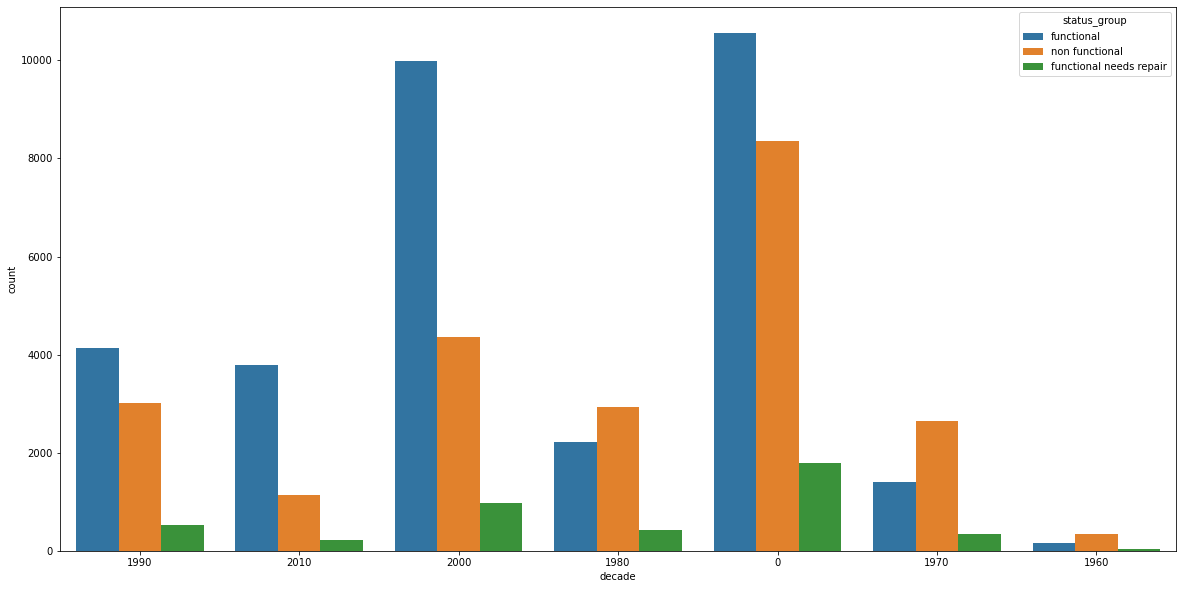

In [118]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x='decade', hue="status_group", data=data)

In [119]:
data["recorded_by"].value_counts() #can be removed same value

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [120]:
data.drop(columns=['recorded_by'],inplace=True ) 
test.drop(columns=['recorded_by'],inplace=True ) 

Fixing missing Values and 0 values

In [121]:
data.isnull().sum()*100/train.shape[0]

amount_tsh                0.000000
date_recorded             0.000000
funder                    6.119529
gps_height                0.000000
installer                 6.153199
longitude                 0.000000
latitude                  0.000000
wpt_name                  0.000000
num_private               0.000000
basin                     0.000000
region                    0.000000
district_code             0.000000
lga                       0.000000
ward                      0.000000
population                0.000000
public_meeting            5.612795
scheme_name              47.417508
permit                    5.144781
extraction_type_group     0.000000
management                0.000000
payment                   0.000000
water_quality             0.000000
quantity                  0.000000
source                    0.000000
waterpoint_type           0.000000
status_group              0.000000
decade                    0.000000
dtype: float64

In [122]:
data.astype(bool).sum(axis=0)

amount_tsh               17761
date_recorded            59400
funder                   59400
gps_height               38962
installer                59400
longitude                57588
latitude                 59400
wpt_name                 59400
num_private                757
basin                    59400
region                   59400
district_code            59377
lga                      59400
ward                     59400
population               38019
public_meeting           54345
scheme_name              59400
permit                   41908
extraction_type_group    59400
management               59400
payment                  59400
water_quality            59400
quantity                 59400
source                   59400
waterpoint_type          59400
status_group             59400
decade                   38691
dtype: int64

In [123]:
data.drop(columns=['num_private'],inplace=True )
test.drop(columns=['num_private'],inplace=True )

In [124]:
data.drop(columns=['scheme_name'],inplace=True )
test.drop(columns=['scheme_name'],inplace=True )

In [125]:
data['installer'].fillna(value='None',inplace=True)
test['installer'].fillna(value='None',inplace=True)
data['funder'].fillna(value='None',inplace=True)
test['funder'].fillna(value='None',inplace=True)
data['public_meeting'].fillna(value=True, inplace=True)
test['public_meeting'].fillna(value=True,inplace=True)
data['permit'].fillna(value=True, inplace=True)
test['permit'].fillna(value=True, inplace=True)

data['installer'].replace(to_replace = '0', value ='None' , inplace=True)
test['installer'].replace(to_replace = '0', value ='None' , inplace=True)
data['funder'].replace(to_replace = '0', value ='None' , inplace=True)
test['funder'].replace(to_replace = '0', value ='None' , inplace=True)

data['population'].replace(to_replace = 0 , value =data[data["population"]!=0]["population"].mean(), inplace=True) 
test['population'].replace(to_replace = 0 , value =test[test["population"]!=0]["population"].mean(), inplace=True)

In [126]:
gdf = geopandas.GeoDataFrame(data.copy(),
                            geometry=geopandas.points_from_xy(data.longitude, data.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'Africa'].plot(color='white', edgecolor='black')

gdf.plot(ax=ax, color='red',  figsize=(64, 64))

plt.show()

NameError: name 'geopandas' is not defined

In [127]:
m_lng=data[data["longitude"]!=0]["longitude"].mean()
m_lat=data[data["latitude"]!=0]["latitude"].mean()

In [128]:
data['longitude'].replace(to_replace = 0 , value =m_lng, inplace=True)
test['longitude'].replace(to_replace = 0 , value =m_lng, inplace=True)

data['latitude'].replace(to_replace = 0 , value =m_lat, inplace=True)
test['latitude'].replace(to_replace = 0 , value =m_lat, inplace=True)

Replacing high cardinality columns

In [129]:
data["installer"].value_counts().head(10)

DWE                   17402
None                   4432
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
TCRS                    707
Central government      622
Name: installer, dtype: int64

In [130]:
data['installer_c'] = data['installer'] 
test['installer_c'] = test['installer'] 

In [131]:
installer_cats = ['DWE',
                 'None',
                 'Government',
                 'RWE',
                 'Commu',
                 'DANIDA',
                 'KKKT',
                 'Hesawa',
                 'TCRS',
                 'Central government',
                 'CES',
                 'Community']
data.loc[~data["installer_c"].isin(installer_cats), "installer_c"] = "installer1"
test.loc[~test["installer_c"].isin(installer_cats), "installer_c"] = "installer1"

In [132]:
data["funder"].value_counts().head(10)

Government Of Tanzania    9084
None                      4414
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Kkkt                      1287
World Vision              1246
Unicef                    1057
Tasaf                      877
Name: funder, dtype: int64

In [133]:
data['funder_c'] = data['funder']
test['funder_c'] = test['funder']

fund_cats = ['Government Of Tanzania',
          'Unknown',
          'Danida',
          'Hesawa',
          'Rwssp',
          'World Bank',
          'Kkkt', 
          'World Vision',
          'Unicef',
          'Tasaf']
    

data.loc[~data["funder_c"].isin(fund_cats), "funder_c"] = "Others"
test.loc[~test["funder_c"].isin(fund_cats), "funder_c"] = "Others"

In [134]:
data.drop(columns=['funder','installer'],inplace=True )
test.drop(columns=['funder','installer'],inplace=True )

In [135]:
data["wpt_name"].value_counts()

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

In [136]:
#drop high cardinality column wpt_name
data.drop(columns=['wpt_name'],inplace=True )
test.drop(columns=['wpt_name'],inplace=True )

In [137]:
data.drop(columns=['date_recorded'],inplace=True )
test.drop(columns=['date_recorded'],inplace=True )

In [138]:
data.drop(columns=['lga','ward'],inplace=True )
test.drop(columns=['lga','ward'],inplace=True )

In [139]:
data['permit'] = data['permit'].astype(bool).astype(int) 
test['permit'] = test['permit'].astype(bool).astype(int)

In [140]:
data['public_meeting'] = data['public_meeting'].astype(bool).astype(int) 
test['public_meeting'] = test['public_meeting'].astype(bool).astype(int) 

# Encoding

In [141]:
target_status_group = {'functional':0, 
                       'non functional': 1, 
                       'functional needs repair': 2} 
data['status_group'] = data['status_group'].replace(target_status_group)

In [142]:
y=data.pop("status_group")

In [143]:
x=data
x_t=test

In [144]:
cat_col = ['basin',
           'region',
           'extraction_type_group',
           'management',
           'payment',
           'water_quality',
           'quantity',
           'source',
           'waterpoint_type',
           'decade',
           'installer_c',
           'funder_c']
num_col = ['gps_height',
           'longitude',
           'latitude',
           'district_code',
           'population',
           'public_meeting',
           'permit']

In [145]:
cat=data[cat_col]
con=data[num_col]
cat_t=test[cat_col]
con_t=test[num_col]

In [146]:
x=con.join(pd.get_dummies(cat))
x_t=con_t.join(pd.get_dummies(cat_t))

# Base Model

In [148]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=50)

In [149]:
def evaluate_model(x, y, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

In [150]:
# confusion matrix
def get_confusion(x, y, model):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=50)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    cm=confusion_matrix(y_test, y_pred)
    print(classification_report(y_test,y_pred))
    return cm

In [164]:
class_names=list(train_labels["status_group"].unique())

In [151]:
model=XGBClassifier()

In [160]:
scores = evaluate_model(x, y, model)
print('Base Model Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

array([0.79873737, 0.79292929, 0.79722222, 0.79570707, 0.80075758,
       0.79671717, 0.80126263, 0.79393939, 0.79292929, 0.79208754,
       0.79427609, 0.7952862 , 0.79747475, 0.79469697, 0.79335017])

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:38:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:38:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:39:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [161]:
cm=get_confusion(x, y, model)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:27:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.77      0.91      0.83      6324
           1       0.85      0.73      0.79      4661
           2       0.70      0.25      0.37       895

    accuracy                           0.79     11880
   macro avg       0.77      0.63      0.66     11880
weighted avg       0.79      0.79      0.78     11880



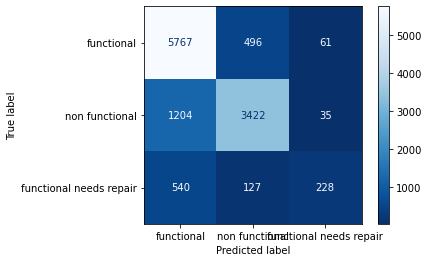

In [165]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(cmap = "Blues_r") 

# Hyperparameter Optimization

In [166]:
def objective(trial: Trial,x,y) -> float:
    
    joblib.dump(study, 'study.pkl')

    param = {
                "n_estimators" : trial.suggest_int('n_estimators', 0, 2000),
                'max_depth':trial.suggest_int('max_depth', 2, 100),
                'reg_alpha':trial.suggest_int('reg_alpha', 0, 20),
                'reg_lambda':trial.suggest_int('reg_lambda', 0, 20),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 20),
                'gamma':trial.suggest_int('gamma', 0, 10),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.005,1),
                'colsample_bytree':trial.suggest_discrete_uniform('colsample_bytree',0.1,1,0.001),
                'nthread' : -1,
                "objective":'multi:softmax'
            }
    
    model = XGBClassifier(**param)
    
    return cross_val_score(model, x, y, cv=3, scoring='accuracy').mean()

In [167]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
study.optimize(lambda trial : objective(trial,x,y),n_trials= 100)

[I 2021-09-17 09:30:44,839] A new study created in memory with name: no-name-3ad437e3-8378-4189-954a-8dba90df2525
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:30:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:31:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:33:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2021-09-17 09:34:11,383] Trial 0 finished with value: 0.7686026936026936 and parameters: {'n_estimators': 531, 'max_depth': 34, 'reg_alpha': 14, 'reg_lambda': 1, 'min_child_weight': 9, 'gamma': 7, 'learning_rate': 0.027385334826457844, 'colsample_bytree': 0.44600000000000006}. Best is trial 0 with value: 0.7686026936026936.


In [168]:
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}={},".format(key, value))

Number of finished trials: 1
Best trial:
  Value: 0.7686026936026936
  Params: 
    n_estimators=531,
    max_depth=34,
    reg_alpha=14,
    reg_lambda=1,
    min_child_weight=9,
    gamma=7,
    learning_rate=0.027385334826457844,
    colsample_bytree=0.44600000000000006,


In [169]:
best_model = XGBClassifier(
    n_estimators=trial.params.get('n_estimators'),
    max_depth=trial.params.get('max_depth'),
    reg_alpha=trial.params.get('reg_alpha'),
    reg_lambda=trial.params.get('reg_lambda'),
    min_child_weight=trial.params.get('min_child_weight'),
    gamma=trial.params.get('gamma'),
    learning_rate=trial.params.get('learning_rate'),
    colsample_bytree=trial.params.get('colsample_bytree')
)

In [ ]:
scores = evaluate_model(x, y, best_model)
print('Best model mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [51]:
cm=get_confusion(x, y, best_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot(cmap = "Blues_r") 

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.006037524364991608, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=992, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=1, reg_lambda=4, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
best_model.fit(x,y)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:37:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.006037524364991608, max_delta_step=0,
              max_depth=25, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=992, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=1, reg_lambda=4, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
indexes=pd.read_csv("test_set_features.csv").iloc[:,0].values
indexes

array([50785, 51630, 17168, ..., 28749, 33492, 68707])

In [57]:
pred=best_model.predict(x_t)

In [58]:
status=pd.DataFrame({"status_group":pred})
target_status_group = {0:'functional', 
                       2:'non functional', 
                       1:'functional needs repair'} 
status['status_group'] = status['status_group'].replace(target_status_group)

In [59]:
id_f=pd.DataFrame({"id":indexes})

In [60]:
out_data=id_f.join(status)

In [61]:
out_data

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


In [63]:
out_data.to_csv("pumpitupsub1.csv",encoding='utf-8', index=False)